In [21]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# === 1. CARGAR DATOS ===
nodos = pd.read_csv("../../data/networks/nodos_IPBLN.csv")
enlaces = pd.read_csv("../../data/networks/coautorias_IPBLN.csv")

# === 2. CONSTRUIR GRAFO ===
G = nx.Graph()

# Añadir nodos (opcional si edges ya los crea)
for _, row in nodos.iterrows():
    G.add_node(row["author_id"], label=row["Label"])  # puedes añadir más atributos si quieres

# Añadir aristas ponderadas
for _, row in enlaces.iterrows():
    G.add_edge(row["Source"], row["Target"], weight=row["Weight"])

In [22]:
# === 3. APLICAR LOUVAIN ===
partition = nx.community.louvain_communities(G, resolution=1, weight='weight')  # Usa edge weights
# partition = nx.community.louvain_communities(G, resolution=0.063, weight='weight') 
# Convertir el conjunto de comunidades a una lista para facilitar el acceso si es necesario
# Aunque para modularidad, la partición tal como la devuelve louvain_communities ya es adecuada
print(f"Número de nodos en el subgrafo: {G.number_of_nodes()}")
print(f"Número de aristas en el subgrafo: {G.number_of_edges()}")

# Extraer número de comunidades
num_comunidades = len(partition)
print(f"Comunidades detectadas: {num_comunidades}")

Número de nodos en el subgrafo: 724
Número de aristas en el subgrafo: 3501
Comunidades detectadas: 71


In [23]:
# === 4. MODULARIDAD ===
# La función modularity espera un grafo y una partición (iterable de conjuntos o listas de nodos)
modularity = nx.community.modularity(G, partition, weight='weight')
print(f"Modularidad de la partición: {modularity:.4f}")

Modularidad de la partición: 0.7852


In [24]:
## Guardamos la partición en un JSON
import json

# Guardar partición en archivo JSON
with open("partition_louvain.json", "w", encoding='utf-8') as f:
    json.dump([list(community) for community in partition], f)

In [25]:
## Cargamos la partición desde el JSON
with open("partition_louvain.json", "r", encoding='utf-8') as f:
    partition = [set(community) for community in json.load(f)]

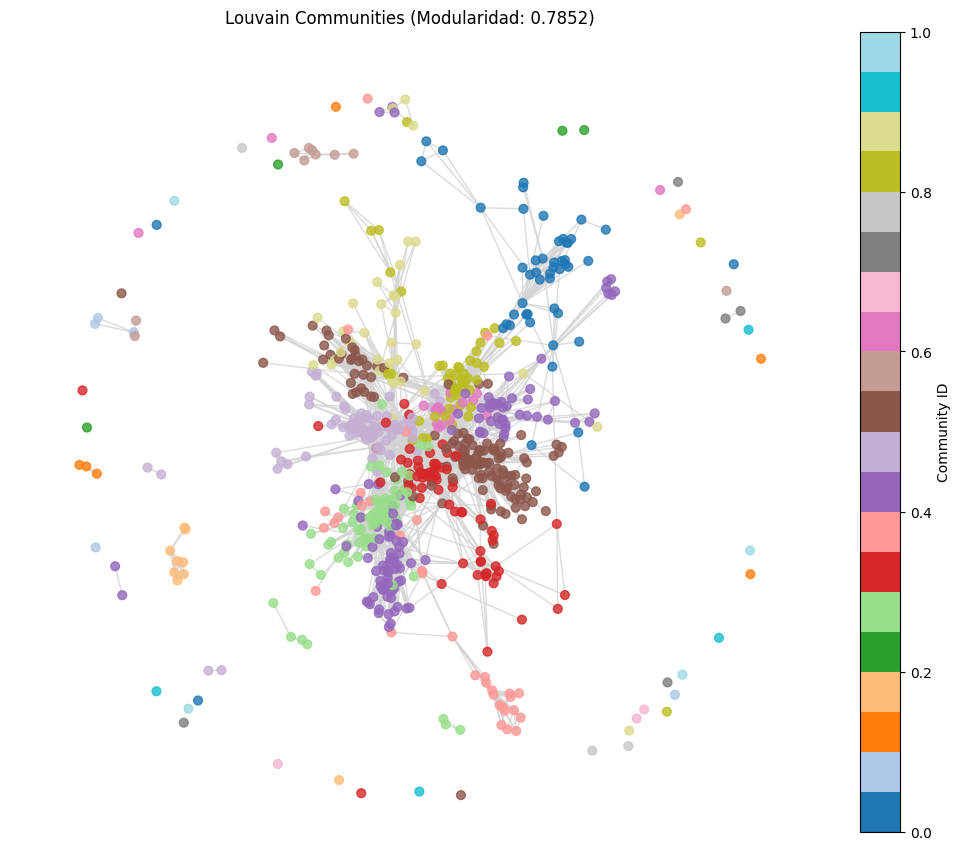

Comunidad 0: [706384]...
Comunidad 1: [327454]...
Comunidad 2: [688307]...
Comunidad 3: [451072, 430465, 451073, 436227, 436484]...
Comunidad 4: [439138, 439139, 439140]...
Comunidad 5: [737621]...
Comunidad 6: [615304]...
Comunidad 7: [747536, 747537, 747538]...
Comunidad 8: [395863]...
Comunidad 9: [699650]...
Comunidad 10: [408845]...
Comunidad 11: [378530, 378531, 378532, 378533, 378534]...
Comunidad 12: [403526]...
Comunidad 13: [403510]...
Comunidad 14: [190734]...
Comunidad 15: [786478]...
Comunidad 16: [594390]...
Comunidad 17: [402720]...
Comunidad 18: [128771, 653061, 768774, 128776, 129161]...
Comunidad 19: [439520, 449530, 341266, 13618]...
Comunidad 20: [747648, 747649, 747647]...
Comunidad 21: [678130]...
Comunidad 22: [21760, 22530, 128140, 747539, 747540]...
Comunidad 23: [420682]...
Comunidad 24: [129152, 164258, 13157, 129126, 342824]...
Comunidad 25: [141632]...
Comunidad 26: [396172]...
Comunidad 27: [128768, 22532, 423951, 433944, 424601]...
Comunidad 28: [22272, 6

In [26]:
# === 5. VISUALIZACIÓN (corregido) ===
pos = nx.spring_layout(G, seed=42) # Usar un seed para reproducibilidad del layout

# Crear un mapeo de nodo a un índice de comunidad
node_community_map = {}
for i, comm in enumerate(partition):
    for node in comm:
        node_community_map[node] = i

# Ahora puedes usar este mapeo para los colores
colors = [node_community_map[node] for node in G.nodes()]

# Dibujar el grafo
plt.figure(figsize=(10, 8)) # Ajusta el tamaño de la figura si es necesario
nx.draw(
    G,
    pos,
    node_color=colors,
    with_labels=False, # Generalmente con muchos nodos, las etiquetas son un desorden
    node_size=40,
    cmap=plt.cm.tab20, # cmap es importante para tener suficientes colores distintivos
    edge_color='lightgray', # Hace que las aristas sean menos dominantes
    alpha=0.8 # Transparencia para ver mejor los nodos
)
plt.title(f"Louvain Communities (Modularidad: {modularity:.4f})")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab20), ax=plt.gca(), orientation='vertical', label='Community ID')
plt.show()

# Opcional: Si quieres ver las etiquetas de comunidad o algunos detalles más
# Puedes imprimir las comunidades para verificar:
for i, comm in enumerate(partition):
   print(f"Comunidad {i}: {list(comm)[:5]}...") # Muestra solo los primeros 5 nodos

In [27]:
# --- Preparar los datos para el CSV ---

# 1. Crear un mapeo de nodo a su ID de comunidad
node_to_community_id = {}
for i, community_nodes in enumerate(partition):
    for node in community_nodes:
        node_to_community_id[node] = i

# 2. Crear una lista de diccionarios para el DataFrame
data = []
for node in G.nodes():
    data.append({
        'author_id': node,
        'Community_ID': node_to_community_id.get(node, -1) # Usar .get para manejar nodos que por alguna razón no estén en una comunidad (aunque con Louvain no debería pasar)
    })

# 3. Crear el DataFrame de Pandas
df_communities = pd.DataFrame(data)

# 4. Guardar el DataFrame en un archivo CSV
output_filename = '../../Data/networks/nodes_with_communities.csv'
df_communities.to_csv(output_filename, index=False) # index=False para no guardar el índice de Pandas como una columna

print(f"\nDatos de la comunidad guardados en '{output_filename}'")
print("\nPrimeras 5 filas del DataFrame:")
print(df_communities.head())


Datos de la comunidad guardados en '../../Data/networks/nodes_with_communities.csv'

Primeras 5 filas del DataFrame:
   author_id  Community_ID
0     594285            40
1     427271             3
2     390890            18
3     706384             0
4     345431            29


In [28]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Rutas de tus archivos
json_path = "../../../data/data/IPBLN/json/gesbib_authors_ipbln_info.json"
communities_csv_path = "../../data/networks/nodes_with_communities.csv" # El CSV que generaste antes
all_nodes_csv_path = "../../data/networks/nodos_IPBLN.csv" # CSV con todos los nodos (asignados y no asignados)

# --- 2. Cargar y Preprocesar los Datos de los Autores (NLP) ---

# Cargar JSON con información de autores
with open(json_path, encoding="utf-8") as f:
    author_data_raw = json.load(f)

# El JSON es un diccionario donde las claves son los IDs de autor (como strings)
# No necesitas convertirlo, ya está en el formato deseado: id_autor -> info_autor
author_info_dict = author_data_raw

# Cargar el CSV con todos los nodos (para obtener todos los IDs y Labels)
df_all_nodes = pd.read_csv(all_nodes_csv_path)

# Cargar el CSV de comunidades (para los nodos de la componente gigante)
df_communities = pd.read_csv(communities_csv_path)

# Preparar los datos textuales de todos los autores
processed_author_texts = []
author_ids_with_text = []

# Iterar sobre todos los autores en df_all_nodes para asegurar que procesamos todos
for author_id_int in df_all_nodes['author_id']:
    # El ID en el JSON es una cadena, asegúrate de que coincida el tipo
    author_id_str = str(author_id_int)
    info = author_info_dict.get(author_id_str)

    if info:
        # Extraer y combinar los campos de texto
        # Si son diccionarios, queremos las claves (las materias/palabras clave)
        materias_jcr = " ".join(info.get('materiasJcr', {}).keys())
        materias_cs = " ".join(info.get('materiasCs', {}).keys())

        combined_text = f"{materias_jcr} {materias_cs}".lower()
        # Limpieza básica: eliminar espacios extra
        combined_text = ' '.join(combined_text.split())

        processed_author_texts.append(combined_text)
        author_ids_with_text.append(author_id_int) # Guardamos el ID como entero
    else:
        # Manejar autores para los que no se encontró información detallada
        processed_author_texts.append("") # Texto vacío
        author_ids_with_text.append(author_id_int)

# Crear un DataFrame con todos los autores y su texto combinado
df_all_authors_text = pd.DataFrame({
    'author_id': author_ids_with_text,
    'combined_text': processed_author_texts
})

# Fusionar con la información de las comunidades ya asignadas
# Asegúrate de que 'id_autor' en df_communities es numérico si el tuyo no lo es
df_all_authors_info = df_all_nodes.merge(df_all_authors_text, on='author_id', how='left')
df_all_authors_info = df_all_authors_info.merge(df_communities[['author_id', 'Community_ID']], on='author_id', how='left')

# Los nodos no asignados de la componente gigante tendrán NaN en 'Community_ID'
df_all_authors_info['Community_ID'] = df_all_authors_info['Community_ID'].fillna(-1).astype(int)

print("--- DataFrame consolidado con texto y Community_ID ---")
print(df_all_authors_info.head())
print(f"\nTotal de autores: {len(df_all_authors_info)}")
print(f"Autores con Community_ID asignada (de Louvain): {df_all_authors_info[df_all_authors_info['Community_ID'] != -1].shape[0]}")
print(f"Autores sin Community_ID asignada (a clasificar): {df_all_authors_info[df_all_authors_info['Community_ID'] == -1].shape[0]}")

--- DataFrame consolidado con texto y Community_ID ---
   author_id                      Label  \
0     594285         Palacios Mejía, F.   
1     427271                Verdejo, S.   
2     390890            Barreiro, Laura   
3     706384          de Groof, Aurélie   
4     345431  Herrera Campos, Ana Belén   

                                       combined_text  Community_ID  
0                                                               40  
1  zoology ecology, evolution, behavior and syste...             3  
2        biochemistry & molecular biology biophysics            18  
3                                                                0  
4  oncology genetics & heredity biotechnology & a...            29  

Total de autores: 724
Autores con Community_ID asignada (de Louvain): 724
Autores sin Community_ID asignada (a clasificar): 0


In [29]:
from collections import defaultdict

# --- 3. Mapeo de Comunidades de Louvain a Departamentos (Sección Automática/Semi-Automática) ---
json_path = "../../../data/data/IPBLN/json/gesbib_authors_ipbln_info.json"

# Cargar JSON
with open(json_path, encoding="utf-8") as f:
    author_data = json.load(f)

rows = []
# Crear estructura para almacenar datos
for author_id, data in author_data.items():
    materias = defaultdict(int)
    
    # Añadir materias JCR
    for m, v in data.get("materiasJcr", {}).items():
        materias[m.lower().strip()] += v
        
    # Añadir materias CS
    for m, v in data.get("materiasCs", {}).items():
        materias[m.lower().strip()] += v

    # Crear fila
    row = {"author_id": author_id}
    row.update(materias)
    rows.append(row)

# Crear DataFrame
df = pd.DataFrame(rows)
df = df.fillna(0)  # reemplazar NaNs con 0
# Mostrar resumen
print(f"Autores: {df.shape[0]} | Materias distintas: {df.shape[1] - 1}")
df.head()

Autores: 972 | Materias distintas: 335


,author_id,"chemistry, organic","chemistry, medicinal","chemistry, multidisciplinary",materials chemistry,molecular biology,pharmaceutical science,general medicine,clinical biochemistry,metals and alloys,...,regional & urban planning,"management, monitoring, policy and law",nature and landscape conservation,nuclear science & technology,radiation,otorhinolaryngology,"medicine, legal",mathematical physics,small animals,urban studies
0,2078,3.0,2.0,4.0,1.0,1.0,1.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2105,3.0,0.0,6.0,2.0,2.0,5.0,7.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4243,1.0,0.0,1.0,0.0,29.0,1.0,38.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4244,7.0,4.0,4.0,0.0,34.0,3.0,67.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13157,6.0,6.0,82.0,50.0,4.0,11.0,28.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
